# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

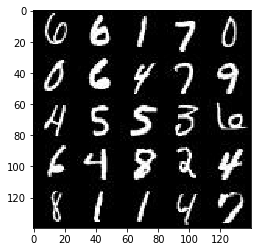

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

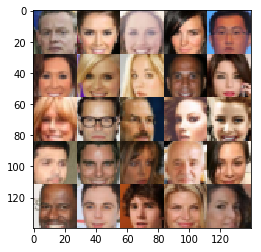

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim))
    learning_rate = tf.placeholder(dtype=tf.float32)

    return r_input, z_input, learning_rate

    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False,alpha=.2,dropout=.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    initializer = tf.contrib.layers.xavier_initializer()
    keep_prob = 0.5
       
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 14x14x32
                
        
        conv1 = tf.layers.conv2d(images, 32, 4, strides=2, padding='same', kernel_initializer=initializer)
        conv1d = tf.layers.dropout(conv1, rate=(keep_prob), training=True)
        conv1r = tf.maximum(alpha * conv1d, conv1d)
        # 7x7x64
        
        conv2 = tf.layers.conv2d(conv1r, 64, 4, strides=2, padding='same', kernel_initializer=initializer)
        conv2d = tf.layers.dropout(conv2, rate=(keep_prob), training=True)
        conv2n = tf.layers.batch_normalization(conv2d, training=True)
        conv2r = tf.maximum(alpha * conv2n, conv2n)
        # 4x4x128
        
        conv3 = tf.layers.conv2d(conv2r, 128, 4, strides=2, padding='same', kernel_initializer=initializer)
        conv3d = tf.layers.dropout(conv3, rate=(keep_prob), training=True)
        conv3n = tf.layers.batch_normalization(conv3d, training=True)
        conv3r = tf.maximum(alpha * conv3n, conv3n)

        # Flatten it
        flat = tf.reshape(conv3r, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    initializer = tf.contrib.layers.xavier_initializer()
    keep_prob = 0.5
          

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
       
        denseL = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        dense_r = tf.reshape(denseL, (-1, 4, 4, 256))
        dense_rn = tf.layers.batch_normalization(dense_r, training=is_train)
        dense_rnr = tf.maximum(alpha * dense_rn, dense_rn)
        
        
        conv_2 = tf.layers.conv2d_transpose(dense_rnr, 64, 4, strides=2, padding='same',
                                            kernel_initializer = initializer)
        conv_2n = tf.layers.batch_normalization(conv_2, training=is_train)
        conv_2nr = tf.maximum(alpha * conv_2n, conv_2n)
        conv_2d = tf.layers.dropout(conv_2nr, rate=(keep_prob), training=is_train)
       
        # 4x4x256 now
        #change from 5 to 4 below
        conv_2 = tf.layers.conv2d_transpose(dense_rnr, 128, 4, strides=1, padding='valid', kernel_initializer=initializer)
        conv_2d = tf.layers.dropout(conv_2, rate=(keep_prob), training=is_train)
        conv_2n = tf.layers.batch_normalization(conv_2d, training=is_train)
        conv_2nr = tf.maximum(alpha * conv_2n,conv_2n)
        # print(x2.shape)
        # 7x7x128 now
        
        conv_3 = tf.layers.conv2d_transpose(conv_2nr, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        conv_3d = tf.layers.dropout(conv_3, rate=(keep_prob), training=is_train)
        conv_3n = tf.layers.batch_normalization(conv_3d, training=is_train)
        conv_3nr = tf.maximum(alpha * conv_3n, conv_3n)
        # print(x3.shape)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv_3nr, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=initializer)
        # print(logits.shape)
        # 28x28x5 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2,dropout=0.8, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True,alpha=alpha)
    
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
       
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha=alpha, dropout=dropout)
        
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
      
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
       
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
        
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
   
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
             
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
             
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
   
    
    _, img_width, img_height, n_channels = data_shape
    img, z, learn_rate = model_inputs(img_width, img_height, n_channels, z_dim)
    d_loss, g_loss = model_loss(img, z, n_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            
            steps = 0
            d_loss_sum = 0
            g_loss_sum = 0
            batch_count = 0
            
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_count += 1
                batch_images * 2
                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                _ = sess.run(d_opt, feed_dict={img: batch_images, z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z, learn_rate: learning_rate})

                d_loss_sum += d_loss.eval({z: batch_z, img: batch_images})
                g_loss_sum += g_loss.eval({z: batch_z,img:batch_images})

                
                if steps% 100 == 0:
                    
                    
                    show_generator_output(sess, 16, z, n_channels, data_image_mode)
                    
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count,steps),
                          "Avg. Discriminator Loss: {:.4f}...".format(d_loss_sum / batch_count),
                          "Avg. Generator Loss: {:.4f}".format(g_loss_sum / batch_count))   
                    
                    
                    d_loss_sum = 0
                    g_loss_sum = 0
                    
                    
                    batch_count = 0

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

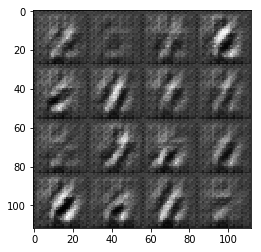

Epoch 1/2 Step 100... Avg. Discriminator Loss: 1.4854... Avg. Generator Loss: 1.1715


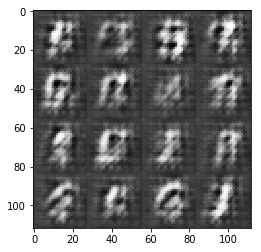

Epoch 1/2 Step 200... Avg. Discriminator Loss: 1.3622... Avg. Generator Loss: 1.0060


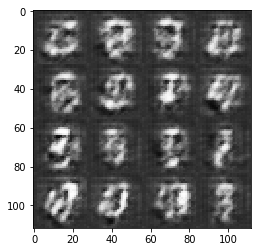

Epoch 1/2 Step 300... Avg. Discriminator Loss: 1.2820... Avg. Generator Loss: 1.0259


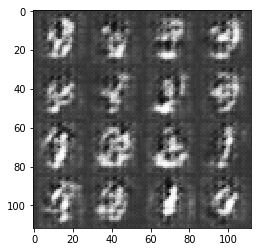

Epoch 1/2 Step 400... Avg. Discriminator Loss: 1.1598... Avg. Generator Loss: 1.1957


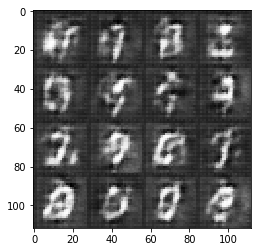

Epoch 1/2 Step 500... Avg. Discriminator Loss: 0.9858... Avg. Generator Loss: 1.5322


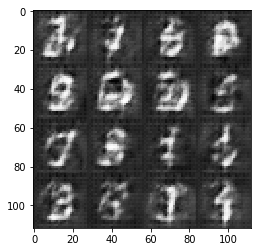

Epoch 1/2 Step 600... Avg. Discriminator Loss: 0.8857... Avg. Generator Loss: 1.8740


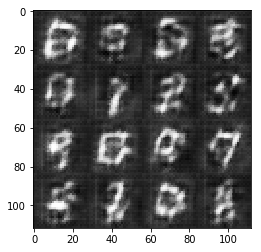

Epoch 1/2 Step 700... Avg. Discriminator Loss: 0.8318... Avg. Generator Loss: 2.0353


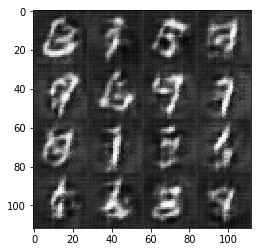

Epoch 1/2 Step 800... Avg. Discriminator Loss: 0.8156... Avg. Generator Loss: 2.0977


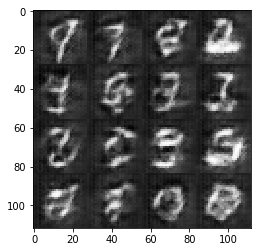

Epoch 1/2 Step 900... Avg. Discriminator Loss: 0.7307... Avg. Generator Loss: 2.3122


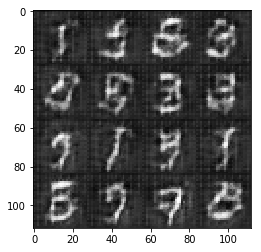

Epoch 1/2 Step 1000... Avg. Discriminator Loss: 0.6742... Avg. Generator Loss: 2.6184


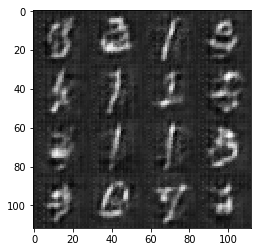

Epoch 1/2 Step 1100... Avg. Discriminator Loss: 0.6635... Avg. Generator Loss: 2.6696


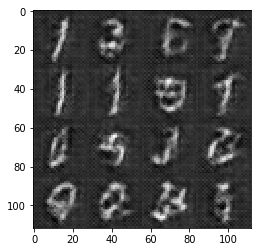

Epoch 1/2 Step 1200... Avg. Discriminator Loss: 0.5919... Avg. Generator Loss: 2.8370


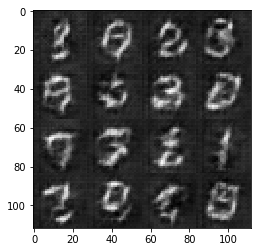

Epoch 1/2 Step 1300... Avg. Discriminator Loss: 0.5912... Avg. Generator Loss: 3.0805


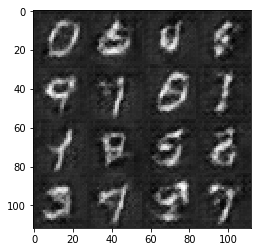

Epoch 1/2 Step 1400... Avg. Discriminator Loss: 0.5360... Avg. Generator Loss: 3.1665


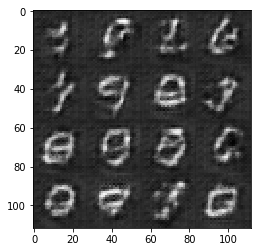

Epoch 1/2 Step 1500... Avg. Discriminator Loss: 0.6086... Avg. Generator Loss: 3.2481


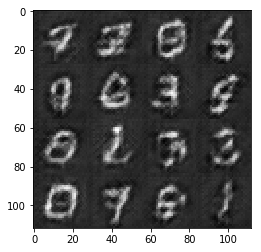

Epoch 1/2 Step 1600... Avg. Discriminator Loss: 0.5208... Avg. Generator Loss: 3.2785


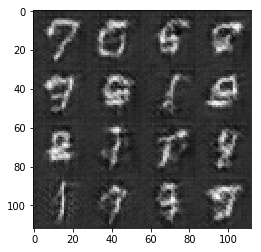

Epoch 1/2 Step 1700... Avg. Discriminator Loss: 0.5986... Avg. Generator Loss: 3.2007


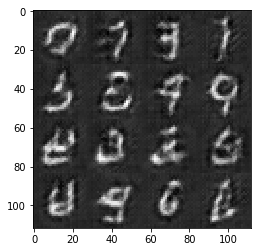

Epoch 1/2 Step 1800... Avg. Discriminator Loss: 0.6198... Avg. Generator Loss: 2.9616


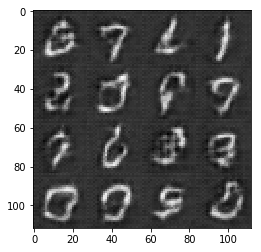

Epoch 2/2 Step 100... Avg. Discriminator Loss: 0.4537... Avg. Generator Loss: 3.6848


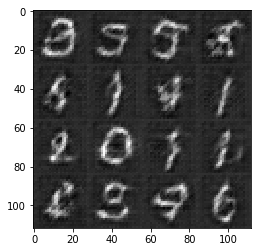

Epoch 2/2 Step 200... Avg. Discriminator Loss: 0.6264... Avg. Generator Loss: 3.4690


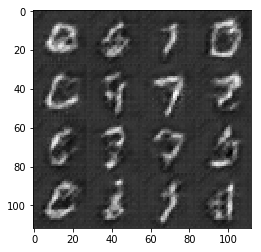

Epoch 2/2 Step 300... Avg. Discriminator Loss: 0.4616... Avg. Generator Loss: 3.5029


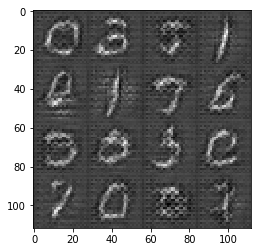

Epoch 2/2 Step 400... Avg. Discriminator Loss: 0.5552... Avg. Generator Loss: 3.5817


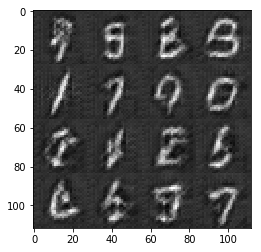

Epoch 2/2 Step 500... Avg. Discriminator Loss: 0.6383... Avg. Generator Loss: 3.4987


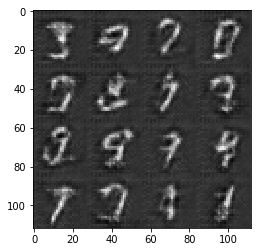

Epoch 2/2 Step 600... Avg. Discriminator Loss: 0.4775... Avg. Generator Loss: 3.2715


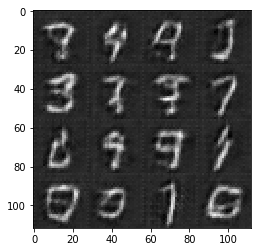

Epoch 2/2 Step 700... Avg. Discriminator Loss: 0.6028... Avg. Generator Loss: 3.3890


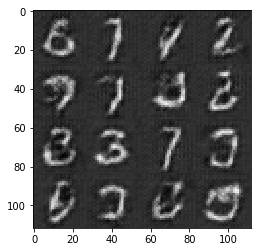

Epoch 2/2 Step 800... Avg. Discriminator Loss: 0.5049... Avg. Generator Loss: 3.4446


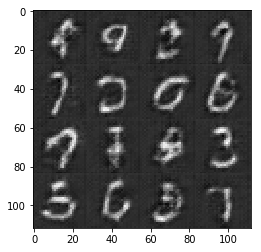

Epoch 2/2 Step 900... Avg. Discriminator Loss: 0.4322... Avg. Generator Loss: 4.0131


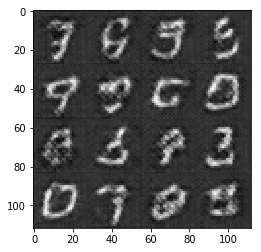

Epoch 2/2 Step 1000... Avg. Discriminator Loss: 0.5791... Avg. Generator Loss: 3.2930


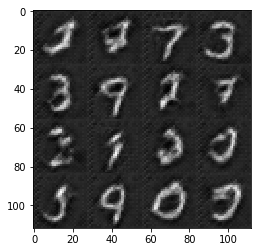

Epoch 2/2 Step 1100... Avg. Discriminator Loss: 0.4222... Avg. Generator Loss: 3.9562


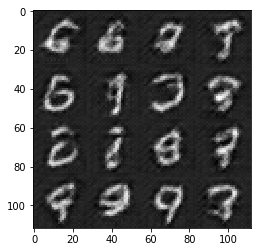

Epoch 2/2 Step 1200... Avg. Discriminator Loss: 0.4159... Avg. Generator Loss: 4.0019


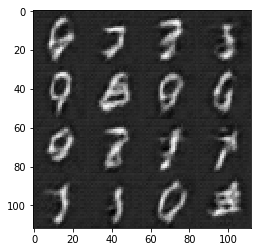

Epoch 2/2 Step 1300... Avg. Discriminator Loss: 0.4193... Avg. Generator Loss: 4.0628


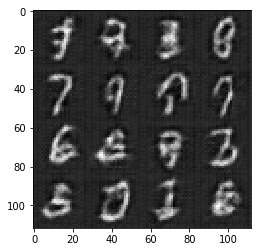

Epoch 2/2 Step 1400... Avg. Discriminator Loss: 0.5514... Avg. Generator Loss: 3.7742


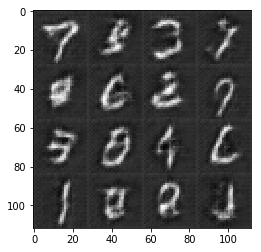

Epoch 2/2 Step 1500... Avg. Discriminator Loss: 0.4299... Avg. Generator Loss: 3.7960


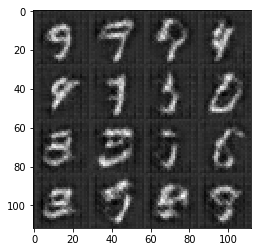

Epoch 2/2 Step 1600... Avg. Discriminator Loss: 0.6630... Avg. Generator Loss: 3.3599


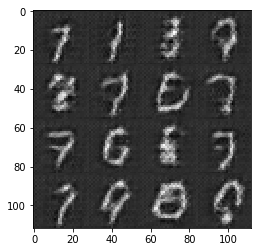

Epoch 2/2 Step 1700... Avg. Discriminator Loss: 0.4501... Avg. Generator Loss: 3.7606


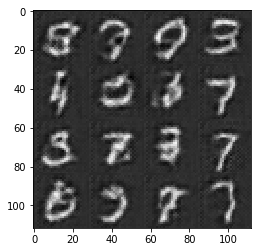

Epoch 2/2 Step 1800... Avg. Discriminator Loss: 0.4858... Avg. Generator Loss: 3.6878


In [28]:
batch_size = 32
z_dim = 120
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

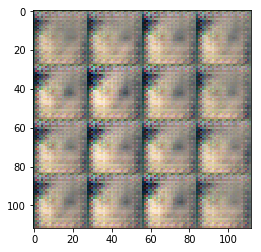

Epoch 1/1 Step 100... Avg. Discriminator Loss: 1.1673... Avg. Generator Loss: 2.0422


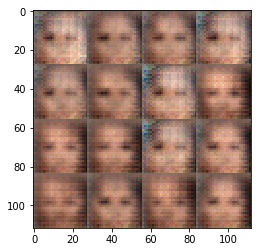

Epoch 1/1 Step 200... Avg. Discriminator Loss: 1.2329... Avg. Generator Loss: 1.2682


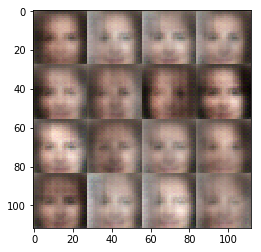

Epoch 1/1 Step 300... Avg. Discriminator Loss: 1.3803... Avg. Generator Loss: 0.9433


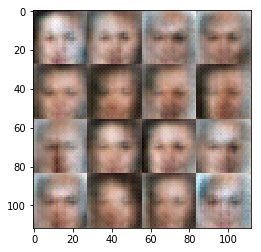

Epoch 1/1 Step 400... Avg. Discriminator Loss: 1.3543... Avg. Generator Loss: 0.8759


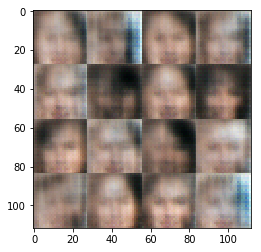

Epoch 1/1 Step 500... Avg. Discriminator Loss: 1.3581... Avg. Generator Loss: 0.8860


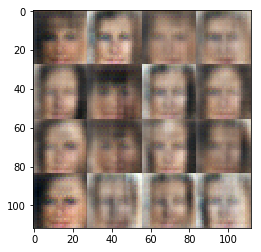

Epoch 1/1 Step 600... Avg. Discriminator Loss: 1.3413... Avg. Generator Loss: 0.8840


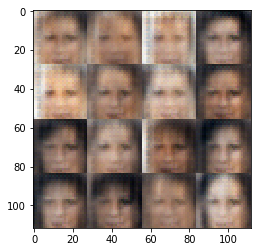

Epoch 1/1 Step 700... Avg. Discriminator Loss: 1.3447... Avg. Generator Loss: 0.8875


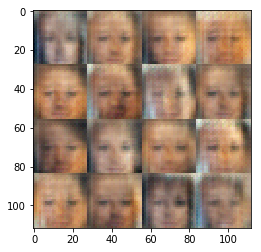

Epoch 1/1 Step 800... Avg. Discriminator Loss: 1.3356... Avg. Generator Loss: 0.8973


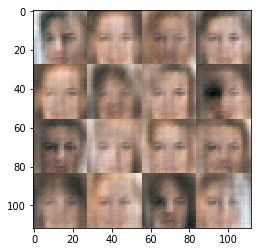

Epoch 1/1 Step 900... Avg. Discriminator Loss: 1.3316... Avg. Generator Loss: 0.9047


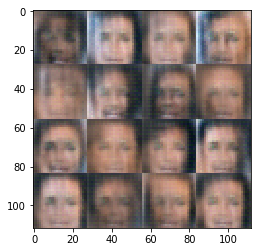

Epoch 1/1 Step 1000... Avg. Discriminator Loss: 1.3388... Avg. Generator Loss: 0.9045


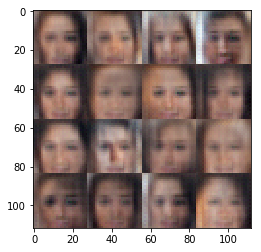

Epoch 1/1 Step 1100... Avg. Discriminator Loss: 1.3197... Avg. Generator Loss: 0.9166


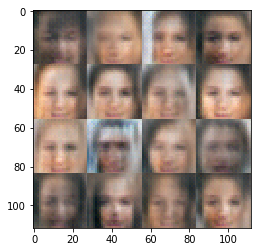

Epoch 1/1 Step 1200... Avg. Discriminator Loss: 1.2923... Avg. Generator Loss: 0.9392


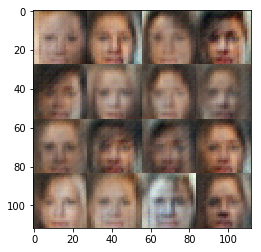

Epoch 1/1 Step 1300... Avg. Discriminator Loss: 1.3023... Avg. Generator Loss: 0.9519


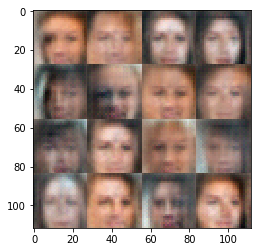

Epoch 1/1 Step 1400... Avg. Discriminator Loss: 1.2816... Avg. Generator Loss: 0.9456


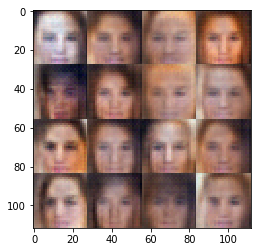

Epoch 1/1 Step 1500... Avg. Discriminator Loss: 1.2611... Avg. Generator Loss: 1.0255


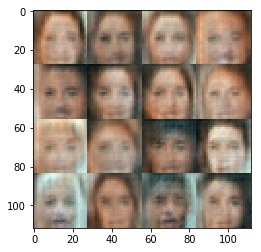

Epoch 1/1 Step 1600... Avg. Discriminator Loss: 1.2427... Avg. Generator Loss: 0.9910


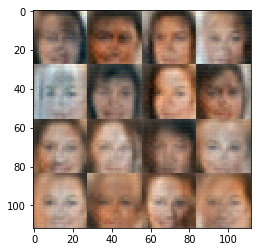

Epoch 1/1 Step 1700... Avg. Discriminator Loss: 1.2470... Avg. Generator Loss: 0.9913


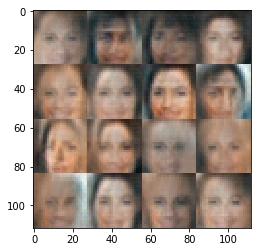

Epoch 1/1 Step 1800... Avg. Discriminator Loss: 1.2358... Avg. Generator Loss: 1.0128


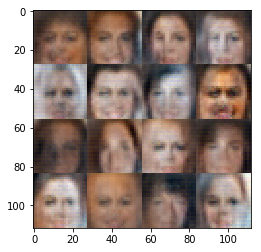

Epoch 1/1 Step 1900... Avg. Discriminator Loss: 1.2155... Avg. Generator Loss: 1.0554


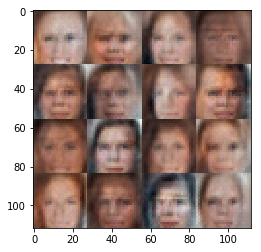

Epoch 1/1 Step 2000... Avg. Discriminator Loss: 1.2293... Avg. Generator Loss: 1.0485


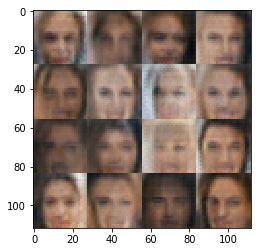

Epoch 1/1 Step 2100... Avg. Discriminator Loss: 1.2286... Avg. Generator Loss: 1.0274


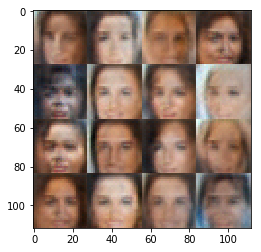

Epoch 1/1 Step 2200... Avg. Discriminator Loss: 1.2235... Avg. Generator Loss: 1.0575


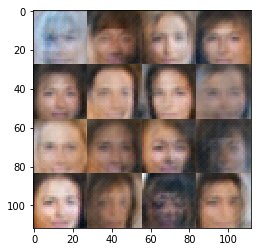

Epoch 1/1 Step 2300... Avg. Discriminator Loss: 1.2395... Avg. Generator Loss: 1.0673


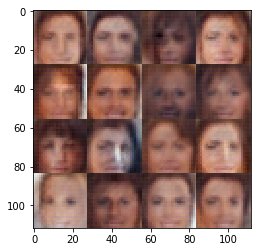

Epoch 1/1 Step 2400... Avg. Discriminator Loss: 1.2001... Avg. Generator Loss: 1.0888


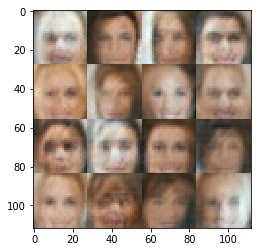

Epoch 1/1 Step 2500... Avg. Discriminator Loss: 1.2177... Avg. Generator Loss: 1.0780


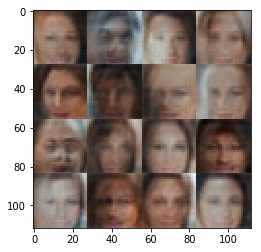

Epoch 1/1 Step 2600... Avg. Discriminator Loss: 1.1976... Avg. Generator Loss: 1.1019


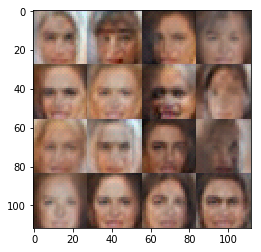

Epoch 1/1 Step 2700... Avg. Discriminator Loss: 1.1953... Avg. Generator Loss: 1.1177


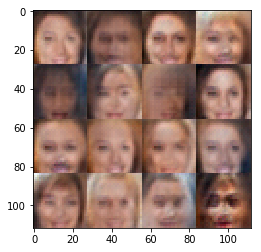

Epoch 1/1 Step 2800... Avg. Discriminator Loss: 1.1642... Avg. Generator Loss: 1.1312


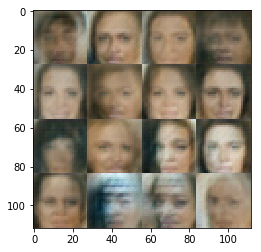

Epoch 1/1 Step 2900... Avg. Discriminator Loss: 1.1886... Avg. Generator Loss: 1.1559


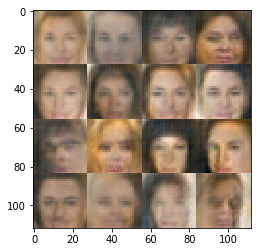

Epoch 1/1 Step 3000... Avg. Discriminator Loss: 1.1929... Avg. Generator Loss: 1.1414


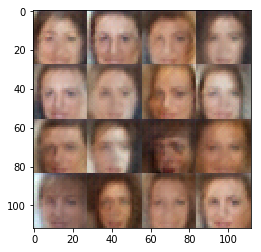

Epoch 1/1 Step 3100... Avg. Discriminator Loss: 1.1805... Avg. Generator Loss: 1.1420


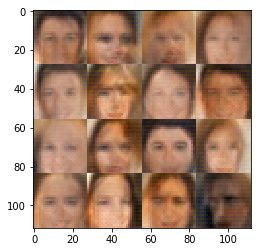

Epoch 1/1 Step 3200... Avg. Discriminator Loss: 1.1621... Avg. Generator Loss: 1.1600


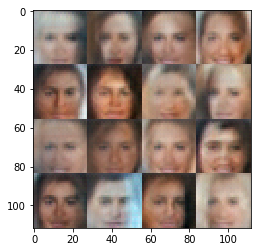

Epoch 1/1 Step 3300... Avg. Discriminator Loss: 1.1859... Avg. Generator Loss: 1.1294


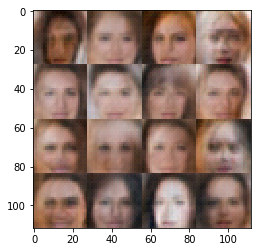

Epoch 1/1 Step 3400... Avg. Discriminator Loss: 1.1817... Avg. Generator Loss: 1.1747


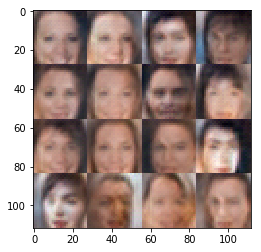

Epoch 1/1 Step 3500... Avg. Discriminator Loss: 1.1495... Avg. Generator Loss: 1.1643


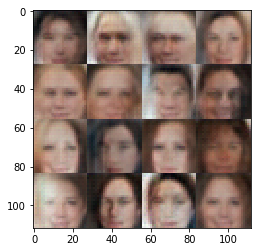

Epoch 1/1 Step 3600... Avg. Discriminator Loss: 1.1330... Avg. Generator Loss: 1.2002


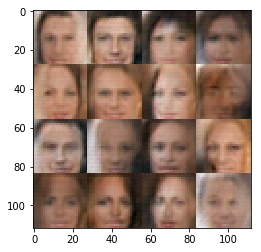

Epoch 1/1 Step 3700... Avg. Discriminator Loss: 1.1228... Avg. Generator Loss: 1.2231


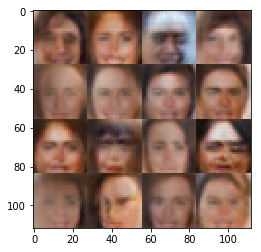

Epoch 1/1 Step 3800... Avg. Discriminator Loss: 1.1230... Avg. Generator Loss: 1.1997


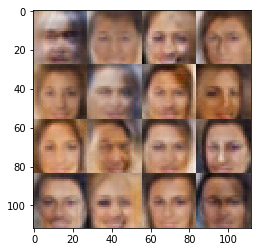

Epoch 1/1 Step 3900... Avg. Discriminator Loss: 1.1495... Avg. Generator Loss: 1.2251


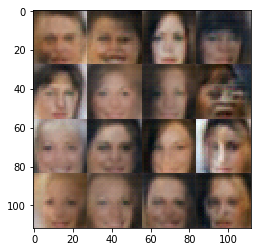

Epoch 1/1 Step 4000... Avg. Discriminator Loss: 1.1305... Avg. Generator Loss: 1.2128


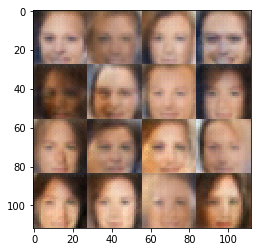

Epoch 1/1 Step 4100... Avg. Discriminator Loss: 1.1442... Avg. Generator Loss: 1.3043


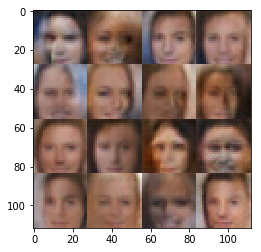

Epoch 1/1 Step 4200... Avg. Discriminator Loss: 1.1342... Avg. Generator Loss: 1.2375


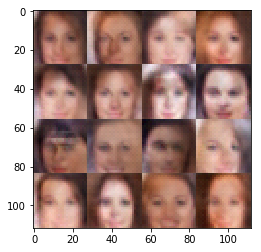

Epoch 1/1 Step 4300... Avg. Discriminator Loss: 1.0942... Avg. Generator Loss: 1.2894


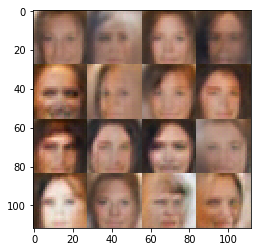

Epoch 1/1 Step 4400... Avg. Discriminator Loss: 1.1055... Avg. Generator Loss: 1.2725


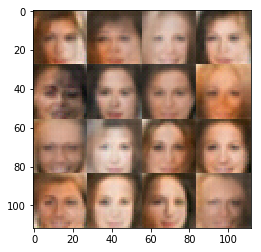

Epoch 1/1 Step 4500... Avg. Discriminator Loss: 1.0771... Avg. Generator Loss: 1.3324


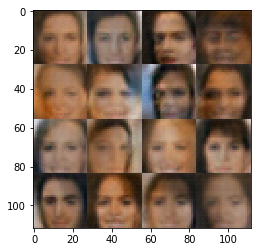

Epoch 1/1 Step 4600... Avg. Discriminator Loss: 1.1157... Avg. Generator Loss: 1.3035


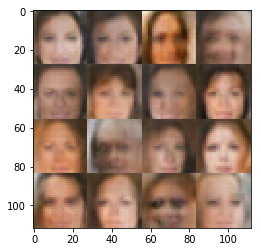

Epoch 1/1 Step 4700... Avg. Discriminator Loss: 1.1000... Avg. Generator Loss: 1.3595


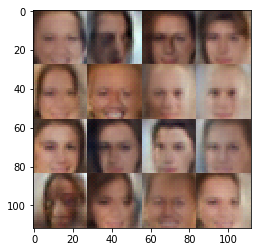

Epoch 1/1 Step 4800... Avg. Discriminator Loss: 1.0824... Avg. Generator Loss: 1.3415


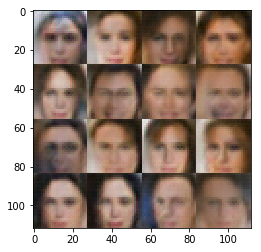

Epoch 1/1 Step 4900... Avg. Discriminator Loss: 1.0737... Avg. Generator Loss: 1.3422


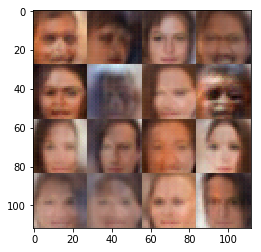

Epoch 1/1 Step 5000... Avg. Discriminator Loss: 1.0966... Avg. Generator Loss: 1.3791


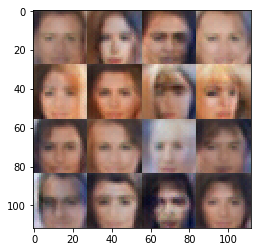

Epoch 1/1 Step 5100... Avg. Discriminator Loss: 1.0738... Avg. Generator Loss: 1.4224


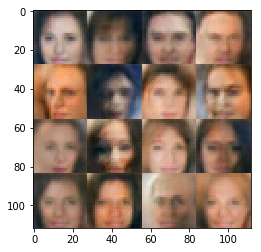

Epoch 1/1 Step 5200... Avg. Discriminator Loss: 1.0773... Avg. Generator Loss: 1.3857


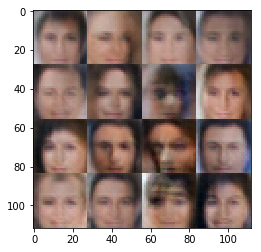

Epoch 1/1 Step 5300... Avg. Discriminator Loss: 1.0628... Avg. Generator Loss: 1.4105


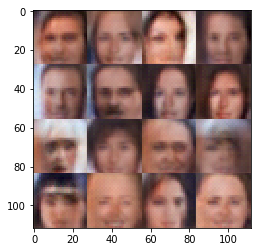

Epoch 1/1 Step 5400... Avg. Discriminator Loss: 1.0522... Avg. Generator Loss: 1.3946


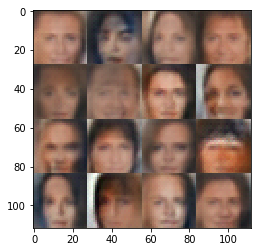

Epoch 1/1 Step 5500... Avg. Discriminator Loss: 1.0285... Avg. Generator Loss: 1.4316


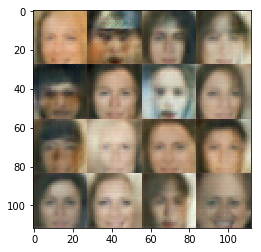

Epoch 1/1 Step 5600... Avg. Discriminator Loss: 1.0745... Avg. Generator Loss: 1.4130


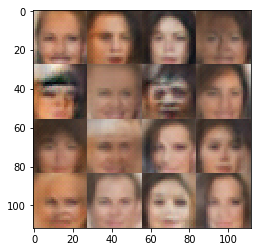

Epoch 1/1 Step 5700... Avg. Discriminator Loss: 1.0667... Avg. Generator Loss: 1.4065


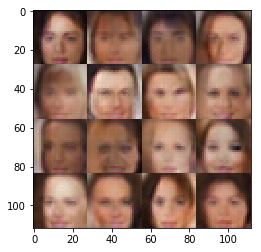

Epoch 1/1 Step 5800... Avg. Discriminator Loss: 1.0473... Avg. Generator Loss: 1.4797


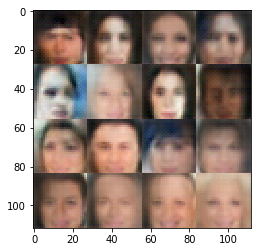

Epoch 1/1 Step 5900... Avg. Discriminator Loss: 1.0021... Avg. Generator Loss: 1.4559


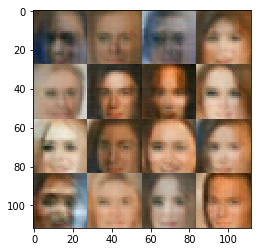

Epoch 1/1 Step 6000... Avg. Discriminator Loss: 1.0358... Avg. Generator Loss: 1.5235


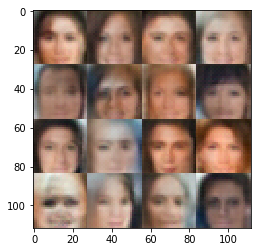

Epoch 1/1 Step 6100... Avg. Discriminator Loss: 1.0225... Avg. Generator Loss: 1.5037


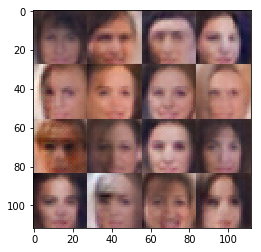

Epoch 1/1 Step 6200... Avg. Discriminator Loss: 0.9919... Avg. Generator Loss: 1.5336


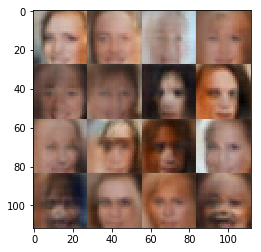

Epoch 1/1 Step 6300... Avg. Discriminator Loss: 1.0136... Avg. Generator Loss: 1.5160


In [29]:
batch_size = 32
z_dim = 120
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In case of MNIST dataset the discriminator gets strong very soon whereas in the case of celebrity images dataset the discriminator is smae as compaed to generator.